In [13]:
import tensorflow as tf
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt

import pathlib
import numpy as np
import pandas as pd

SEQUENCE_LENGTH = 50  # Evaluate on sequences of 15 days
LOOKUP_SIZE = 1  # Predict next day
FEATURES = ['negative_avg', 'positive_avg', 'neutral_avg', 'total_count']


         date  negative_avg  positive_avg  neutral_avg  total_count  new_cases
0  2020-01-22      0.297759      0.046364     0.655877      36333.0        0.0
1  2020-01-23      0.496623      0.036621     0.466757     203690.0        0.0
2  2020-01-24      0.421975      0.053221     0.524804     568486.0        3.0
3  2020-01-25      0.442639      0.040343     0.517018     856089.0        1.0
4  2020-01-26      0.429384      0.027735     0.542881    1137737.0        4.0


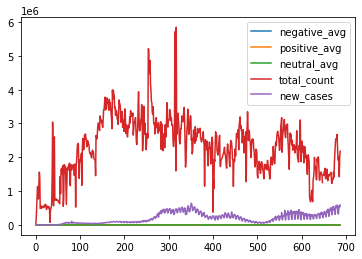

In [2]:
SENTIMENT_DATA = pathlib.Path('../data/Sent_by_day.csv')
COVID_DATA = pathlib.Path('../data/owid-covid-data.csv')
PROCESSED_DATA = pathlib.Path('../data/processed_data_unaveraged.csv')

def data_processing():
    # Check if processed data file exists
    if PROCESSED_DATA.exists():
        return pd.read_csv(PROCESSED_DATA)

    # Otherwise, process raw data
    sentiment_data = pd.read_csv(SENTIMENT_DATA, index_col=0, parse_dates=[['Year', 'Month', 'Day']])
    sentiment_data.index.rename('date', inplace=True)
    sentiment_data.drop(['Unnamed: 0'], axis=1, inplace=True)
    negative_data = sentiment_data[sentiment_data['Sentiment'] == 'negative']
    positive_data = sentiment_data[sentiment_data['Sentiment'] == 'positive']
    neutral_data = sentiment_data[sentiment_data['Sentiment'] == 'neutral']
    sentiment_data = pd.concat([negative_data, positive_data, neutral_data], axis=1, join="inner")
    sentiment_data = sentiment_data.drop(['Sentiment'], axis=1)
    sentiment_data.columns = ['negative_count', 'negative_avg', 'positive_count', 'positive_avg', 'neutral_count', 'neutral_avg']
    sentiment_data['total_count'] = sentiment_data.negative_count + sentiment_data.positive_count + sentiment_data.neutral_count
    sentiment_data.drop(['negative_count', 'positive_count', 'neutral_count'], axis=1, inplace=True)
    sentiment_data = sentiment_data.groupby(['date']).sum()

    daily_data = pd.read_csv(COVID_DATA, index_col=3, parse_dates=['date'])
    daily_data = daily_data[daily_data.continent.isin(['Europe', 'North America'])]
    daily_data = daily_data['new_cases'].groupby(daily_data.index).sum()
    daily_data = daily_data[daily_data.index >= pd.to_datetime('2020-01-22')]
    daily_data = daily_data[daily_data.index <= pd.to_datetime('2021-12-09')]

    ret = pd.concat((sentiment_data, daily_data), axis=1)
    ret.to_csv('../data/processed_data_unaveraged.csv')
    return ret

data = data_processing()
print(data.head())
data.plot()
plt.show()

In [3]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=5, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=[loss], optimizer=optimizer)
    return model

In [14]:
import os
import time

model_name = "model_" + time.strftime("%Y%m%d-%H%M%S")
model = create_model(sequence_length=SEQUENCE_LENGTH, n_features=len(FEATURES), units=256, cell=LSTM, n_layers=5, dropout=0.3,
                loss=Huber(), optimizer=RMSprop(), bidirectional=False)
model.summary()
checkpoint = ModelCheckpoint(os.path.join("../models", model_name), monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# Split data into SEQUENCE_LENGTH days
def split_data(data):
    X = []
    y = []
    for i in range(len(data) - SEQUENCE_LENGTH - LOOKUP_SIZE):
        X.append(data[i:i + SEQUENCE_LENGTH][FEATURES])
        y.append(data[i + SEQUENCE_LENGTH:i + SEQUENCE_LENGTH + LOOKUP_SIZE]['new_cases'])

    return np.array(X), np.array(y)

data_x, data_y = split_data(data)
data_x = np.asarray(data_x).astype('float32')
data_y = np.asarray(data_y).astype('float32')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50, 256)           267264    
                                                                 
 dropout_5 (Dropout)         (None, 50, 256)           0         
                                                                 
 lstm_6 (LSTM)               (None, 50, 256)           525312    
                                                                 
 dropout_6 (Dropout)         (None, 50, 256)           0         
                                                                 
 lstm_7 (LSTM)               (None, 50, 256)           525312    
                                                                 
 dropout_7 (Dropout)         (None, 50, 256)           0         
                                                                 
 lstm_8 (LSTM)               (None, 50, 256)          

In [ ]:
history = model.fit(data_x, data_y,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[checkpoint]
                    )

Epoch 1/100
15/16 [===========================>..] - ETA: 0s - loss: nan - mean_absolute_error: nan  
Epoch 00001: val_loss did not improve from inf
16/16 [==============================] - 6s 107ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/100
15/16 [===========================>..] - ETA: 0s - loss: nan - mean_absolute_error: nan